In [34]:
folder_path = "E:/ravdess/Audio/tessavee"


In [35]:
import librosa
from librosa import display

data, sampling_rate = librosa.load(r'E:\ravdess\Audio\Song+Speech\Audio_Song_Actors_01-24\Actor_01\03-02-01-01-01-01-01.wav')

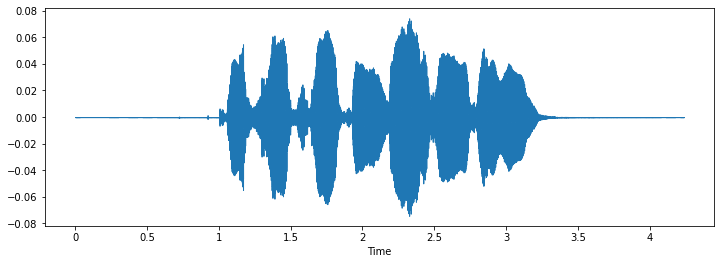

In [36]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob 

plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sampling_rate)

load files

In [37]:
import time
import numpy as np
path = 'E:/ravdess/Audio/tessavee'
print(path)
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file))
        print(X)
        print("-------------")
        print(sample_rate)
        #print("*****************************************")
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        print("mfccs=",mfccs,"file=",file)
        arr = mfccs, file
        lst.append(arr)
        #print(lst)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

E:/ravdess/Audio/tessavee
[ 2.9371402e-05 -9.6096061e-05  7.1829214e-05 ... -5.0388198e-06
  8.1723440e-05  1.8374536e-05]
-------------
22050
mfccs= [-3.7996924e+02  7.7316551e+01 -7.5440621e+00  1.4912173e+01
 -7.6501036e+00  3.8817897e+00 -1.1608627e+01 -1.1511995e+01
 -3.0017705e+00 -3.5705590e-01 -9.7472448e+00 -3.6839082e+00
 -8.1736441e+00  6.1504173e+00 -9.4307938e+00 -4.5338945e+00
 -2.9785526e-01 -2.5776484e+00 -5.3785238e+00  3.5876161e-01
 -4.5700035e+00 -1.8348227e+00 -1.7013347e+00 -1.6150256e-01
 -3.9217401e+00  1.2172282e+00 -3.2333629e+00  2.3551362e+00
  2.5325968e+00  5.3141274e+00  2.7650001e+00  5.3743677e+00
  1.6080642e+00  1.7440537e+00 -1.9140531e+00  1.6060839e+00
  1.6885529e+00  9.8395866e-01  1.7975973e+00  2.1101410e+00] file= 6
[ 0.00019252 -0.00073993 -0.00155319 ... -0.00032875 -0.00011867
 -0.00011024]
-------------
22050
mfccs= [-3.39606628e+02  7.71935272e+00 -6.41877031e+00  1.67190380e+01
 -1.90383129e+01 -5.99199724e+00 -1.94136396e-01 -1.45297194

In [38]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [39]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((3220, 40), (3220,))

In [40]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = os.getcwd()

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [41]:
# Loading saved models

X = joblib.load('X.joblib')
y = joblib.load('y.joblib')

Decesion tree classifier

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Neural network

In [43]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [44]:
x_traincnn.shape, x_testcnn.shape

((2157, 40, 1), (1063, 40, 1))

In [45]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras import layers, models, callbacks
from tensorflow.python.keras import regularizers


# Construction du modèle DCNN
model = models.Sequential([
    layers.Conv1D(64, 5, activation='relu', input_shape=(40, 1)),
    layers.BatchNormalization(),
    layers.Conv1D(64, 5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(128, 5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv1D(128, 5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(256, 5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv1D(256, 5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')  # Nombre de classes
])

opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

C:\Users\Naj La\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 36, 64)            384       
                                                                 
 batch_normalization_6 (Batc  (None, 36, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_7 (Conv1D)           (None, 36, 64)            20544     
                                                                 
 batch_normalization_7 (Batc  (None, 36, 64)           256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 18, 64)           0         
 1D)                                                             
                                                      

In [47]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [48]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
es=EarlyStopping(monitor="val_accuracy",min_delta=0.01, patience=5, verbose=1)
model_cp=ModelCheckpoint(filepath="modelCNNtessavee.h5",monitor="val_accuracy",save_best_only=True,verbose=1)

In [49]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=60, validation_data=(x_testcnn, y_test),verbose=1,callbacks=model_cp)

Epoch 1/60
68/68 [==============================] - ETA: 0s - loss: 1.2493 - accuracy: 0.6606
Epoch 1: val_accuracy improved from -inf to 0.52117, saving model to modelCNNtessavee.h5
68/68 [==============================] - 10s 80ms/step - loss: 1.2493 - accuracy: 0.6606 - val_loss: 1.8788 - val_accuracy: 0.5212
Epoch 2/60
67/68 [============================>.] - ETA: 0s - loss: 0.5763 - accuracy: 0.8778
Epoch 2: val_accuracy improved from 0.52117 to 0.62935, saving model to modelCNNtessavee.h5
68/68 [==============================] - 6s 88ms/step - loss: 0.5754 - accuracy: 0.8785 - val_loss: 1.4154 - val_accuracy: 0.6294
Epoch 3/60
67/68 [============================>.] - ETA: 0s - loss: 0.3765 - accuracy: 0.9090
Epoch 3: val_accuracy improved from 0.62935 to 0.87394, saving model to modelCNNtessavee.h5
68/68 [==============================] - 6s 89ms/step - loss: 0.3766 - accuracy: 0.9091 - val_loss: 0.7445 - val_accuracy: 0.8739
Epoch 4/60
67/68 [============================>.] - ET

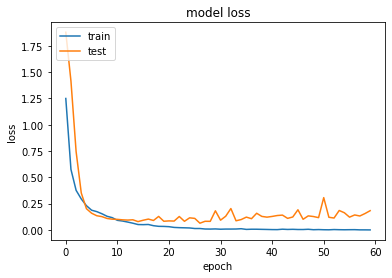

In [50]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

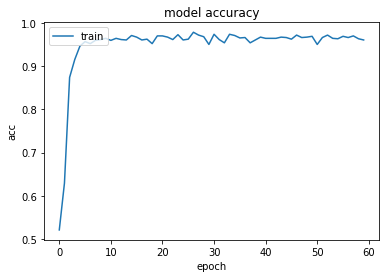

In [51]:
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
predictions = model.predict(x_testcnn)

34/34 [==============================] - 1s 10ms/step


In [53]:
predictions

array([[5.5054583e-09, 1.6368772e-09, 6.2878186e-08, ..., 3.4008451e-07,
        2.3830023e-06, 9.9999702e-01],
       [2.6933617e-06, 3.2312249e-07, 1.5394568e-06, ..., 1.1608423e-06,
        6.2349398e-05, 2.5639035e-06],
       [2.3301681e-08, 4.6034089e-08, 1.7290977e-04, ..., 3.4087996e-06,
        9.9981791e-01, 3.2808346e-06],
       ...,
       [4.0627859e-11, 2.8386049e-10, 2.2583681e-10, ..., 2.4318632e-09,
        9.9999988e-01, 1.3351950e-08],
       [8.2824364e-12, 7.6794549e-13, 3.7674397e-10, ..., 8.9205496e-09,
        2.3647251e-09, 1.0000000e+00],
       [2.2324741e-06, 8.5170457e-09, 9.9985838e-01, ..., 7.4160787e-05,
        3.0854246e-06, 3.2767224e-05]], dtype=float32)

In [54]:
# Generate arg maxes for predictions
classes = np.argmax(predictions, axis = 1)
print(classes)

[7 3 6 ... 6 7 2]


In [55]:
y_test

array([7, 3, 6, ..., 6, 7, 2])

In [56]:
new_Ytest = y_test.astype(int)

In [57]:
new_Ytest

array([7, 3, 6, ..., 6, 7, 2])

In [58]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, classes)
print(report)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       170
           2       0.97      0.94      0.96       157
           3       0.99      0.94      0.96       146
           4       0.90      0.99      0.94       140
           5       0.97      0.96      0.96       157
           6       0.99      0.91      0.94       151
           7       0.99      0.99      0.99       142

    accuracy                           0.96      1063
   macro avg       0.96      0.96      0.96      1063
weighted avg       0.96      0.96      0.96      1063



In [59]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, classes)
print(report)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       170
           2       0.97      0.94      0.96       157
           3       0.99      0.94      0.96       146
           4       0.90      0.99      0.94       140
           5       0.97      0.96      0.96       157
           6       0.99      0.91      0.94       151
           7       0.99      0.99      0.99       142

    accuracy                           0.96      1063
   macro avg       0.96      0.96      0.96      1063
weighted avg       0.96      0.96      0.96      1063



In [60]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, classes)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[170   0   0   0   0   0   0]
 [  0 148   0   5   3   0   1]
 [  9   0 137   0   0   0   0]
 [  0   1   1 138   0   0   0]
 [  0   2   1   2 150   2   0]
 [  4   0   0   8   1 137   1]
 [  0   1   0   0   0   0 141]]


In [61]:
model_name = 'modelCNNtessavee.h5'
save_dir = os.getcwd()
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at c:\Users\Naj La\Desktop\ScanEmotion\modelCNNtessavee.h5 


Pickel model

In [62]:
import joblib

In [63]:
with open('modelCNNtessavee.pkl','wb') as file:
    joblib.dump(model,file)

INFO:tensorflow:Assets written to: ram://874ed857-6db3-4c93-9c14-1dbdadd6d0e8/assets


INFO:tensorflow:Assets written to: ram://874ed857-6db3-4c93-9c14-1dbdadd6d0e8/assets


In [64]:
loaded_model = keras.models.load_model('./modelCNNtessavee.h5')
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 36, 64)            384       
                                                                 
 batch_normalization_6 (Batc  (None, 36, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_7 (Conv1D)           (None, 36, 64)            20544     
                                                                 
 batch_normalization_7 (Batc  (None, 36, 64)           256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 18, 64)           0         
 1D)                                                             
                                                      

check accuracy

In [65]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))


34/34 [==============================] - 1s 10ms/step - loss: 0.1831 - accuracy: 0.9605
Restored model, accuracy: 96.05%
